## Model Evaluation
1. Preprocess the bounding box output of running the inference graph - [bb_hashmap_schneider_v0.2.scv](http://localhost:8080/edit/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_bb_prediction/bb_hashmap_schneider_v0.2.csv). This will make it fit to pass throught the object_detection_evaluation module of the tensorflow's object detection API
2. Run the evaluation on data to get the class wise evaluation metrics - Precision, Recall, Average Precision and mean Average Precision 

In [1]:
import csv, os, sys, json
import pandas as pd
import numpy as np

from object_detection.core import standard_fields
from object_detection.utils import object_detection_evaluation

import sys
if sys.version_info[0] >= 3:
    unicode = str
    
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#### Preparing the bb_hashmap_schneider.csv for the object_detection_evaluation.py function
- Reading the data from disk
- maintaining the data types - formatting was done manually on csv output
- removing the no prediction records

**The box encoding for detection - (ymin, xmin, ymax, xmax), for Schneider's data - (xmin, ymin, xmax, ymax)**

In [2]:
Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"

gold_standard_bb_temp = {}
with open((Project_filepath + 'Data/GoldStandardBoundBoxCoord.csv'), 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['filename']]
        if filename not in gold_standard_bb_temp.keys():
            gold_standard_bb_temp[filename] = {}
            gold_standard_bb_temp[filename]['width'] = int(row[col_mapper['width']])
            gold_standard_bb_temp[filename]['height'] = int(row[col_mapper['height']])

# gold_standard_bb_temp

In [3]:
# Reading the data
# Box encoding - (ymin, xmin, ymax, xmax)
bb_hashmap_path = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_bb_prediction/'
# reading each record in the and adding 
bb_hashmap_path_dict = {}
with open(os.path.join(bb_hashmap_path, 'bb_hashmap_schneider_v04.csv'), 'r', newline='') as csvfile:
    for row in (csvfile):
        image_key = row.split(':{')[0]
        detection = '{' + row.split(':{')[1]
        detection = detection.replace("'", '"')
        detection_dict = json.loads(detection)
        if len(detection_dict['detection_classes']) != 0:
            detection_dict['detection_boxes'] = \
            np.array([[unscales*gold_standard_bb_temp[image_key]['width'] if i in [1, 3] else \
              unscales*gold_standard_bb_temp[image_key]['height'] \
              for i, unscales in enumerate(inner)] \
              for inner in detection_dict['detection_boxes']]) # Rescaling the coordinates
            bb_hashmap_path_dict[image_key] = detection_dict
#         print((detection_dict['detection_boxes']))

In [4]:
bb_hashmap_path_dict['ASG000bi7r.jpg']

{'detection_boxes': array([[ 333.56199936,  439.09996544, 1488.579072  , 1988.9494016 ]]),
 'detection_classes': [17],
 'detection_scores': [0.99869895]}

**Removing the instances of no prediction**

lila label map:<br>
{"otherBird": 22, "buffalo": 14, "batEaredFox": 23, "ostrich": 19, "hartebeest": 15, "vervetMonkey": 34, "impala": 10, "wildebeest": 17, "dikDik": 4, "porcupine": 6, "jackal": 25, "guineaFowl": 16, "aardvark": 31, "rhinoceros": 46, "waterbuck": 35, "hyenaSpotted": 8, "human": 1, "serval": 37, "bushbuck": 24, "zebra": 5, "wildcat": 42, "hippopotamus": 29, "reptiles": 47, "leopard": 18, "gazelleThomsons": 7, "rodents": 41, "hare": 32, "caracal": 45, "civet": 43, "mongoose": 13, "warthog": 9, "honeyBadger": 40, "topi": 39, "unrecognizeable": 1000, "gazelleGrants": 2, "hyenaStriped": 30, "zorilla": 48, "reedbuck": 3, "koriBustard": 21, "aardwolf": 28, "genet": 44, "baboon": 33, "secretaryBird": 36, "elephant": 11, "lionMale": 38, "eland": 27, "cheetah": 26, "lionFemale": 20, "giraffe": 12}

schneider label map:<br>
{"GazelleGrants": 16, "Porcupine": 36, "Human": 17, "SuperbStarling": 30, "Stork": 24, "Rhinoceros": 45, "GreyBackedFiscal": 23, "KoriBustard": 11, "Topi": 26, "BuffCrestedBustard": 29, "Mongoose": 39, "HyenaSpotted": 9, "WattledStarling": 13, "Cheetah": 28, "Elephant": 20, "Lion": 31, "Eland": 21, "Serval": 42, "OtherBird": 7, "WhiteHeadBuffaloWeaver": 38, "Aardvark": 32, "GazelleThomsons": 4, "Oxpecker": 22, "Jackal": 33, "Ostrich": 35, "Zebra": 2, "Hartebeest": 10, "Wildebeest": 1, "Baboon": 8, "DikDik": 18, "Rodent": 44, "Bushbuck": 27, "Warthog": 14, "Aardwolf": 40, "Reedbuck": 15, "Impala": 12, "Hippopotamus": 25, "Leopard": 34, "Waterbuck": 43, "Hare": 41, "Buffalo": 5, "GuineaFowl": 6, "Giraffe": 3, "SecretaryBird": 37, "VervetMonkey": 46, "CattleEgret": 19}

In [5]:
categories = [{"name":"GazelleGrants", "id":2}, 
              {"name":"Porcupine", "id":6}, 
              {"name":"Human", "id":1}, 
              {"name":"Rhinoceros", "id":46}, 
              {"name":"KoriBustard", "id":21}, 
              {"name":"Topi", "id":39}, 
              {"name":"Mongoose", "id":13}, 
              {"name":"HyenaSpotted", "id":8}, 
              {"name":"Cheetah", "id":26}, 
              {"name":"Elephant", "id":11}, 
              {"name":"Lion", "id":20}, 
              {"name":"Eland", "id":27}, 
              {"name":"Serval", "id":37}, 
              {"name":"OtherBird", "id":22}, 
              {"name":"Aardvark", "id":31}, 
              {"name":"GazelleThomsons", "id":7}, 
              {"name":"Jackal", "id":25}, 
              {"name":"Ostrich", "id":19}, 
              {"name":"Zebra", "id":5}, 
              {"name":"Hartebeest", "id":15}, 
              {"name":"Wildebeest", "id":17}, 
              {"name":"Baboon", "id":33}, 
              {"name":"DikDik", "id":4 }, 
              {"name":"Rodent", "id":41},
              {"name":"Bushbuck", "id":24},
              {"name":"Warthog", "id":9},
              {"name":"Aardwolf", "id":28}, 
              {"name":"Reedbuck", "id":3}, 
              {"name":"Impala", "id":10},
              {"name":"Hippopotamus", "id":29},
              {"name":"Leopard", "id":18}, 
              {"name":"Waterbuck", "id":35}, 
              {"name":"Hare", "id":32}, 
              {"name":"Buffalo", "id":14},
              {"name":"GuineaFowl", "id":16}, 
              {"name":"Giraffe", "id":12}, 
              {"name":"SecretaryBird", "id":36}, 
              {"name":"VervetMonkey", "id":34}]

**Preparing the schneider data**

In [6]:
label_map_lila = {"GazelleGrants": 2, "Porcupine": 6, "Human": 1, "Rhinoceros": 46, "KoriBustard": 21, "Topi": 39, "Mongoose": 13, "HyenaSpotted": 8, "Cheetah": 26, "Elephant": 11, "Lion": 20, "Eland": 27, "Serval": 37, "OtherBird": 22, "Aardvark": 31, "GazelleThomsons": 7, "Jackal": 25, "Ostrich": 19, "Zebra": 5, "Hartebeest": 15, "Wildebeest": 17, "Baboon": 33, "DikDik": 4 , "Rodent": 41, "Bushbuck": 24, "Warthog": 9, "Aardwolf": 28, "Reedbuck": 3, "Impala": 10, "Hippopotamus": 29, "Leopard": 18, "Waterbuck": 35, "Hare": 32, "Buffalo": 14, "GuineaFowl": 16, "Giraffe": 12, "SecretaryBird": 36, "VervetMonkey": 34}
print(label_map_lila)

{'Impala': 10, 'Human': 1, 'DikDik': 4, 'Zebra': 5, 'Hippopotamus': 29, 'OtherBird': 22, 'Aardwolf': 28, 'Baboon': 33, 'Hartebeest': 15, 'Reedbuck': 3, 'SecretaryBird': 36, 'Rodent': 41, 'Bushbuck': 24, 'Lion': 20, 'Rhinoceros': 46, 'Porcupine': 6, 'Wildebeest': 17, 'GazelleThomsons': 7, 'Jackal': 25, 'HyenaSpotted': 8, 'GuineaFowl': 16, 'Leopard': 18, 'Warthog': 9, 'Mongoose': 13, 'Buffalo': 14, 'Topi': 39, 'VervetMonkey': 34, 'Serval': 37, 'Cheetah': 26, 'Ostrich': 19, 'KoriBustard': 21, 'Waterbuck': 35, 'Aardvark': 31, 'Eland': 27, 'Giraffe': 12, 'Hare': 32, 'Elephant': 11, 'GazelleGrants': 2}


In [7]:

Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"

gold_standard_bb = {}
with open((Project_filepath + 'Data/GoldStandardBoundBoxCoord.csv'), 'r') as csvfile:
    csvdata = csv.reader(csvfile, delimiter=',')
    header = next(csvdata)
    col_mapper = {k: i for i, k in enumerate(header)}
    for i, row in enumerate(csvdata):
        filename = row[col_mapper['filename']]
        if filename not in gold_standard_bb.keys() and row[col_mapper['class']] in label_map_lila.keys():
            gold_standard_bb[filename] = {}
            detection_boxes = []
            detection_classes = []
            gold_standard_bb[filename]['width'] = int(row[col_mapper['width']])
            gold_standard_bb[filename]['height'] = int(row[col_mapper['height']])
#         {k: row[v] for k, v in col_mapper.items()}
        
        # Having the common animals only
        if row[col_mapper['class']] in label_map_lila.keys():
            xmin_n = float(row[col_mapper['xmin']])# /float(row[col_mapper['width']])
            ymin_n = float(row[col_mapper['ymin']])# /float(row[col_mapper['height']])
            xmax_n = float(row[col_mapper['xmax']])# /float(row[col_mapper['width']])
            ymax_n = float(row[col_mapper['ymax']])# /float(row[col_mapper['height']])
            # since the box encoding for detection is (ymin, xmin, ymax, xmax) re-shuffeling the box encoding order 
            detection_boxes.append([ymin_n, xmin_n, ymax_n, xmax_n])
            detection_classes.append(label_map_lila[row[col_mapper['class']]])
            
            gold_standard_bb[filename]['groundtruth_boxes'] = np.array(detection_boxes)
            gold_standard_bb[filename]['groundtruth_class_labels'] = np.array(detection_classes)
       
        if i%5000 == 0:
            print("performing iteration : %s" % i)

performing iteration : 0
performing iteration : 5000
performing iteration : 10000
performing iteration : 15000


{'width': 2048, 'groundtruth_boxes': array([[1223., 1980., 1330., 2048.],
       [1216., 2021., 1294., 2048.],
       [1234., 1892., 1297., 1975.],
       [1242., 1782., 1269., 1832.],
       [1239., 1561., 1259., 1631.],
       [1205., 1386., 1344., 1588.],
       [1233., 1343., 1255., 1389.],
       [1232., 1229., 1259., 1299.],
       [1218., 1167., 1254., 1207.],
       [1184.,  929., 1338., 1138.],
       [1169.,  874., 1327., 1073.],
       [1200.,  823., 1292.,  962.],
       [1145.,  534., 1345.,  839.],
       [1117.,  392., 1341.,  702.]]), 'height': 1536, 'groundtruth_class_labels': array([17,  5,  5, 17,  5,  5, 17,  5,  5,  5,  5,  5, 17, 17])}
----------------------------
{'detection_classes': [5, 5, 17, 5, 17], 'detection_boxes': array([[1184.36975616,  880.79198208, 1329.2445696 , 1087.06664448],
       [1210.04928   , 1383.9386624 , 1339.857408  , 1571.9839744 ],
       [1119.6098304 ,  391.02881792, 1348.4802048 ,  720.14014464],
       [1236.76032   , 1890.417664  , 

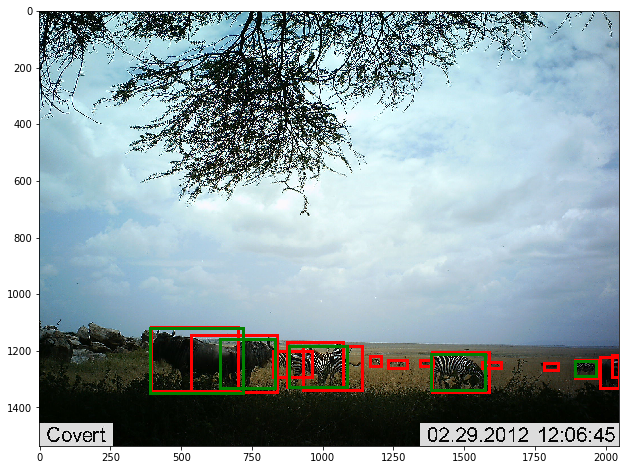

In [27]:
k = list(bb_hashmap_path_dict.keys())
i = 48
print(gold_standard_bb[k[i]])
print('----------------------------')
print(bb_hashmap_path_dict[k[i]])

# plot the image here
img = Image.open(os.path.join('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/', k[i]))
fig,ax = plt.subplots(1)
fig.set_size_inches(12, 8)
# Display the image
ax.imshow(img)
# plot ground truth
gt = gold_standard_bb[k[i]]['groundtruth_boxes']
for box in gold_standard_bb[k[i]]['groundtruth_boxes']:
    rect = patches.Rectangle((box[1],box[0]),abs(box[3]-box[1]), abs(box[2] - box[0]),linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
# plotting the detections with prediction encoding - (ymin, xmin, ymax, xmax)
det = bb_hashmap_path_dict[k[i]]['detection_boxes']
for box in bb_hashmap_path_dict[k[i]]['detection_boxes']:
    rect = patches.Rectangle((box[1],box[0]),abs(box[3]-box[1]), abs(box[2] - box[0]),linewidth=3,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
plt.show()

In [139]:
'/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/' + k[i]

'/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/schneider_images/ASG000d7qe.jpg'

#### Example usage of the Evaluator:
  evaluator = DetectionEvaluator(categories) <br>
#### Detections and groundtruth for image 1.
  evaluator.add_single_groundtruth_image_info(...)<br>
  evaluator.add_single_detected_image_info(...)<br>
#### Detections and groundtruth for image 2.
  evaluator.add_single_groundtruth_image_info(...)<br>
  evaluator.add_single_detected_image_info(...)<br>
  metrics_dict = evaluator.evaluate()<br>

In [17]:
evaluator = object_detection_evaluation.ObjectDetectionEvaluator(
        categories,
        evaluate_precision_recall=False,
        matching_iou_threshold=0.5)

In [18]:
for k, v in bb_hashmap_path_dict.items():
    image_key = k
    # in th detected label, map lionfemale and lion male as one
    detected_boxes = [[float(string) for string in inner] for inner in v['detection_boxes']]
    detected_boxes = np.array([[inner[i] for i in [0, 1, 2, 3]] for inner in detected_boxes]) # reordering the indexes to match up tensorflows box encoding
    detected_scores = np.array(v['detection_scores'])
    detected_class_labels = v['detection_classes']
    detected_class_labels = np.array([i if i not in [20, 38] else 20 for i in detected_class_labels])
    # Add detections
    evaluator.add_single_detected_image_info(image_key, {
    standard_fields.DetectionResultFields.detection_boxes:
            detected_boxes,
    standard_fields.DetectionResultFields.detection_scores:
            detected_scores,
    standard_fields.DetectionResultFields.detection_classes:
            detected_class_labels
            })    

In [19]:
detected_boxes

array([[ 572.96507904, 1586.3498752 ,  831.55041792, 1904.4247552 ],
       [ 610.87875072,  935.38476032,  796.5406464 , 1328.0413696 ],
       [ 643.56197376, 1879.586816  ,  813.98639616, 2048.        ]])

In [20]:
for k, v in  gold_standard_bb.items():
    image_key = k
    groundtruth_boxes = v['groundtruth_boxes']
    groundtruth_class_labels = v['groundtruth_class_labels']
#     groundtruth_is_group_of_list2 = np.array([False, True, False], dtype=bool)

    # Add groundtruth
    evaluator.add_single_ground_truth_image_info(image_key, {
        standard_fields.InputDataFields.groundtruth_boxes:
            groundtruth_boxes,
        standard_fields.InputDataFields.groundtruth_classes:
            groundtruth_class_labels
    })

In [21]:
metrics = evaluator.evaluate()
metrics

/home/ubuntu/data/tensorflow/models/research/object_detection/utils/metrics.py:142: RuntimeWarning: invalid value encountered in true_divide
  num_images_correctly_detected_per_class / num_gt_imgs_per_class)


{"PerformanceByCategory/AP@0.5IOU/b'Aardvark'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Aardwolf'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Baboon'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Buffalo'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Bushbuck'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Cheetah'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'DikDik'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Eland'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Elephant'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'GazelleGrants'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'GazelleThomsons'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Giraffe'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'GuineaFowl'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Hare'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Hartebeest'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Hippopotamus'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Human'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'HyenaSpotted'": 0.0,
 "PerformanceByCategory/AP@0.5IOU/b'Imp

# Building Evaluation for Schneider's Dataset
**Comparing counts in groundtruth vs prediction:**
## Inference on the Schneider data can be run with infer_detections.py

## Round 0
```
TF_RECORD_FILES='/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/test_schneider.record'
OUTPUT_INFERENCE_GRAPH='/home/ubuntu/data/tensorflow/my_workspace/training_demo/backup/jan132019_ckpt.378955plus71016/output_inference_graph/frozen_inference_graph.pb'

python /home/ubuntu/data/tensorflow/models/research/object_detection/inference/infer_detections.py 
  --input_tfrecord_paths=$TF_RECORD_FILES 
  --output_tfrecord_path='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round0.record' \
  --inference_graph=$OUTPUT_INFERENCE_GRAPH 
```

## Round 1
```
TF_RECORD_FILES='/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/test_schneider.record'
# OUTPUT_TFR_PATH ='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round0.record'
OUTPUT_INFERENCE_GRAPH='/home/ubuntu/data/tensorflow/my_workspace/training_demo/backup/booustrap_round1/trained-inference-graphs/output_inference_graph/frozen_inference_graph.pb'

python /home/ubuntu/data/tensorflow/models/research/object_detection/inference/infer_detections.py \
  --input_tfrecord_paths=$TF_RECORD_FILES \
  --output_tfrecord_path='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round1.record' \
  --inference_graph=$OUTPUT_INFERENCE_GRAPH 
```

## Round 2
````
TF_RECORD_FILES='/home/ubuntu/data/tensorflow/my_workspace/training_demo/annotations/test_schneider.record'
# OUTPUT_TFR_PATH ='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round0.record'
OUTPUT_INFERENCE_GRAPH='/home/ubuntu/data/tensorflow/my_workspace/training_demo/backup/booustrap_round2/output_inference_graph/frozen_inference_graph.pb'

python /home/ubuntu/data/tensorflow/models/research/object_detection/inference/infer_detections.py \
  --input_tfrecord_paths=$TF_RECORD_FILES \
  --output_tfrecord_path='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round2.record' \
  --inference_graph=$OUTPUT_INFERENCE_GRAPH 
```

## Use predictor extractor to extract the predictions to a CSV

**For round 0**
```
python predictorExtractor_main.py \
--tfrecord_path_list '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round0.record' \
--output_csv '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round0.csv'
```

**For round 1**
```
python predictorExtractor_main.py \
--tfrecord_path_list '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round1.record' \
--output_csv '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round1.csv'
```

**For round 2**
```
python predictorExtractor_main.py \
--tfrecord_path_list '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round2.record' \
--output_csv '/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round2.csv'
```


## Use prediction_count_aggregation from prediction_groundtruth_consolidation.py to aggregate the prediction information
    - GoldStandardBoundBoxCoord_temp.csv is the groundtruth data

In [12]:
sys.path.append("/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection")

import bootstrapping.prediction_groundtruth_consolidation as pgc
import data_prep.data_prep_utils as dataprep_utils


In [2]:
GoldStandardBoundBoxCoord = pd.read_csv('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Data/GoldStandardBoundBoxCoord_temp.csv')
print(GoldStandardBoundBoxCoord.head(n=2))

         filename  width  height   class  xmin  ymin  xmax  ymax
0  ASG000dz24.jpg   2048    1536  impala  1141   883  1227   977
1  ASG000dz24.jpg   2048    1536  impala  1340   876  1381   925


In [27]:
label_map_json = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/label_map.json'
label_map_df = pd.DataFrame.from_dict(dataprep_utils.get_label_map_from_json(label_map_json), orient='index').reset_index()
label_map_df.columns=['species', 'labels']

In [32]:
groundtruth_dataframe = pd.merge(left=GoldStandardBoundBoxCoord,
                            right=label_map_df,
                            left_on=GoldStandardBoundBoxCoord['class'].str.lower(),
                            right_on=label_map_df['species'].str.lower(),
                            how='inner')

groundtruth_dataframe = groundtruth_dataframe.groupby(by=['filename', 'class', 'labels'], as_index=False)['xmin'].count() \
                        .rename(columns = {'xmin': 'groundtruth_counts', 'class': 'species'}, index=str)


print(groundtruth_dataframe.head())

         filename    species  labels  groundtruth_counts
0  ASG000b3xp.jpg   reedbuck       3                   1
1  ASG000b45v.jpg      zebra       5                   1
2  ASG000b48a.jpg   reedbuck       3                   1
3  ASG000b4c2.jpg   elephant      11                   1
4  ASG000b4cg.jpg  otherBird      22                   1


In [42]:
# Run this by keep changing the round<> to 0, 1 and 2
prediction_df_agg = pgc.prediction_count_aggregation('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round2.csv')
prediction_df_agg['filename'] = [val.split('/')[-1] for val in prediction_df_agg['filename']]
prediction_df_agg.to_csv('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/test_schneider_round2_agg.csv', index=False)
prediction_df_agg.head()

,filename,labels,prediction_counts
0,ASG000b3xp.jpg,3.0,1
1,ASG000b45v.jpg,5.0,1
2,ASG000b48a.jpg,3.0,1
3,ASG000b4c2.jpg,11.0,1
4,ASG000b4cg.jpg,22.0,1


Aggregate the groundtruth schneider data

In [43]:
df = pgc.merged_groundtruth_prediction_dataframe(groundtruth_dataframe, \
                                            prediction_df_agg, \
                                            label_map_df, \
                                            join_type='outer')
df.fillna(0)
df.to_csv('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/pred_groundtruth_consolidate_schneider_round2.csv', index=False)